In [1]:
library('palmerpenguins')

In [2]:
library('tidymodels')

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ dplyr        1.1.4      ✔ tibble       3.2.1 
✔ ggplot2      3.5.1      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.1 
✔ modeldata    1.4.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



In [3]:
library('rpart.plot')

Loading required package: rpart


Attaching package: ‘rpart’


The following object is masked from ‘package:dials’:

    prune




In [4]:
penguins2 = penguins |> drop_na()

penguins2 |> head()

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>
Adelie,Torgersen,39.1,18.7,181,3750,male
Adelie,Torgersen,39.5,17.4,186,3800,female
Adelie,Torgersen,40.3,18.0,195,3250,female
Adelie,Torgersen,36.7,19.3,193,3450,female
Adelie,Torgersen,39.3,20.6,190,3650,male
Adelie,Torgersen,38.9,17.8,181,3625,female


In [5]:
penguins2 |>
    count(species)

species,n
<fct>,<int>
Adelie,146
Chinstrap,68
Gentoo,119


In [6]:
show_engines('decision_tree')

engine,mode
<chr>,<chr>
rpart,classification
rpart,regression
C5.0,classification
spark,classification
spark,regression


## Let's build a decision tree model to predict `species`

In [7]:
mod = decision_tree() |>
    set_engine('rpart') |>
    set_mode('classification')

mod_fit = mod |> fit(species ~ ., data = penguins2)

mod_fit

parsnip model object

n= 333 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 333 187 Adelie (0.438438438 0.204204204 0.357357357)  
  2) flipper_length_mm< 206.5 208  64 Adelie (0.692307692 0.302884615 0.004807692)  
    4) bill_length_mm< 43.35 145   5 Adelie (0.965517241 0.034482759 0.000000000) *
    5) bill_length_mm>=43.35 63   5 Chinstrap (0.063492063 0.920634921 0.015873016) *
  3) flipper_length_mm>=206.5 125   7 Gentoo (0.016000000 0.040000000 0.944000000)  
    6) island=Dream,Torgersen 7   2 Chinstrap (0.285714286 0.714285714 0.000000000) *
    7) island=Biscoe 118   0 Gentoo (0.000000000 0.000000000 1.000000000) *

In [8]:
predict(mod_fit, penguins2) |>
    bind_cols(penguins2) |>
    head()

.pred_class,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>
Adelie,Adelie,Torgersen,39.1,18.7,181,3750,male
Adelie,Adelie,Torgersen,39.5,17.4,186,3800,female
Adelie,Adelie,Torgersen,40.3,18.0,195,3250,female
Adelie,Adelie,Torgersen,36.7,19.3,193,3450,female
Adelie,Adelie,Torgersen,39.3,20.6,190,3650,male
Adelie,Adelie,Torgersen,38.9,17.8,181,3625,female


Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


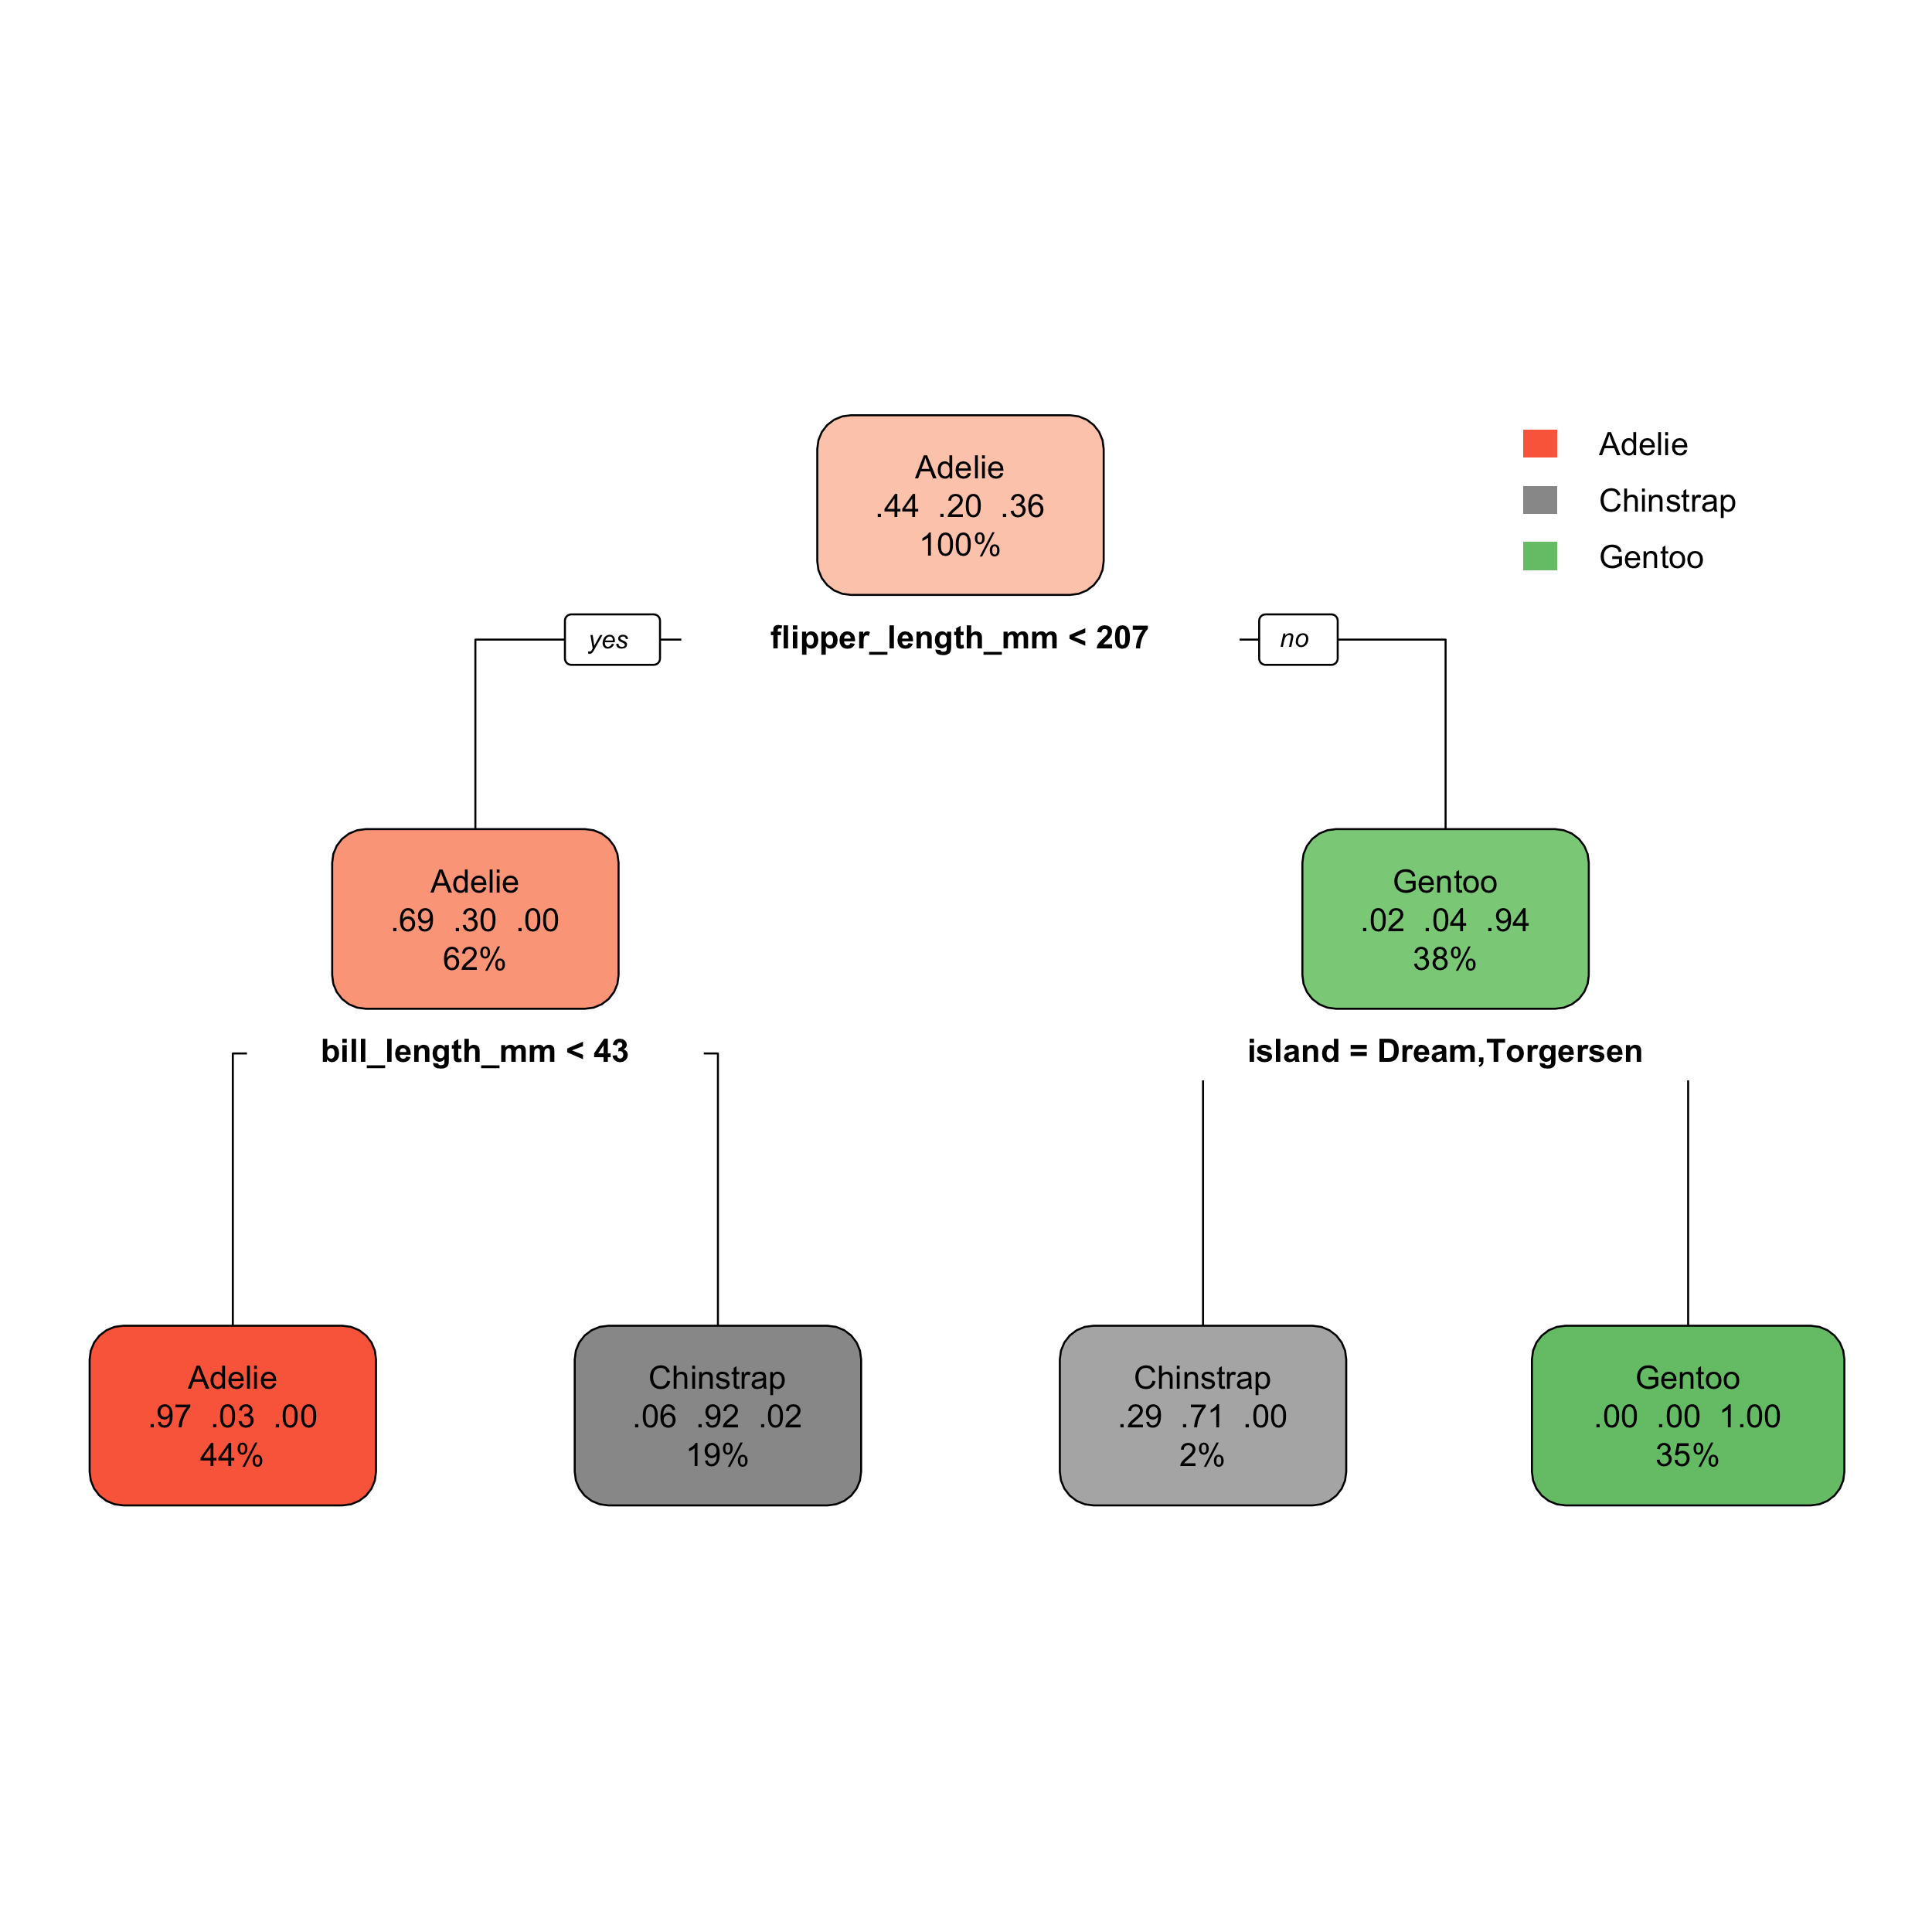

In [9]:
options(repr.plot.height = 10, repr.plot.width = 10, repr.plot.res = 250)

rpart.plot(mod_fit$fit)

## How is a decision tree calculated?

In [10]:
gini_impurity = function(values) {
    freqs = table(values) / length(values)
    (1 - sum(freqs^2)) * 100
}

mean_gini_impurity = function(split_point, penguins_df = penguins2) {
    # assumes splitting variable is "flipper_length_mm"
    
    n1 = penguins_df |> filter(flipper_length_mm < split_point) |> nrow()
    g1 = gini_impurity(
        penguins_df |> 
            filter(flipper_length_mm < split_point) |> 
            pull(species)
    )
    
    n2 = penguins_df |> filter(flipper_length_mm >= split_point) |> nrow()
    g2 = gini_impurity(
        penguins_df |> 
            filter(flipper_length_mm >= split_point) |> 
            pull(species)
    )
    
    weighted.mean(c(g1, g2), c(n1, n2))
}

mean_gini_impurity(190, penguins2)

[1] 55.5799

In [11]:
v = rep('a', 6)

# (1 - ((6 / 6)^2)) * 100

print(v)
gini_impurity(v)

[1] "a" "a" "a" "a" "a" "a"


[1] 0

In [12]:
v = c('a', 'b', 'c', 'd', 'e', 'f')

print(v)
gini_impurity(v)

[1] "a" "b" "c" "d" "e" "f"


[1] 83.33333

In [13]:
gini_impurity(penguins2 |> pull(species))

[1] 63.83681

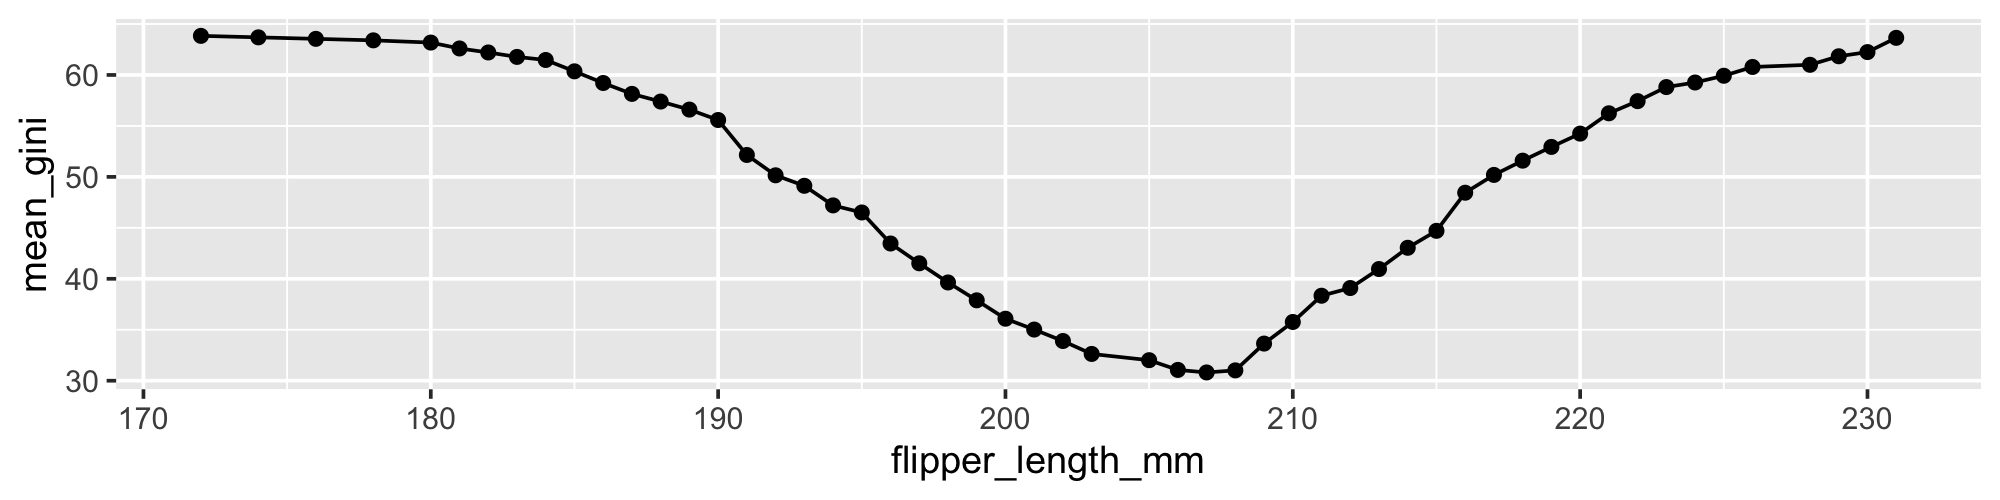

In [14]:
options(repr.plot.height = 2, repr.plot.width = 8)

unique_values = penguins2 |>
    arrange(flipper_length_mm) |>
    pull(flipper_length_mm) |>
    unique() 

tibble::tibble(
    flipper_length_mm = unique_values,
    mean_gini = purrr::map_vec(unique_values, ~mean_gini_impurity(split_point = .x))
) |>
ggplot(aes(x = flipper_length_mm, y = mean_gini)) + 
    geom_point() +
    geom_line()

In [15]:
# decrease in gini impurity
gini_impurity(penguins2 |> pull(species)) - mean_gini_impurity(207, penguins2)

[1] 33.02685

## Let's build a random forest

In [16]:
show_engines('rand_forest')

engine,mode
<chr>,<chr>
ranger,classification
ranger,regression
randomForest,classification
randomForest,regression
spark,classification
spark,regression


In [17]:
mod = rand_forest(trees = 1000) |>
    set_engine('ranger', importance = 'impurity') |>
    set_mode('classification')

mod_fit = mod |> fit(species ~ ., data = penguins2)

In [18]:
mod_fit

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.trees = ~1000,      importance = ~"impurity", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  1000 
Sample size:                      333 
Number of independent variables:  6 
Mtry:                             2 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.01661449 

In [19]:
predict(mod_fit, penguins2) |> bind_cols(penguins2) |> head()

.pred_class,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>
Adelie,Adelie,Torgersen,39.1,18.7,181,3750,male
Adelie,Adelie,Torgersen,39.5,17.4,186,3800,female
Adelie,Adelie,Torgersen,40.3,18.0,195,3250,female
Adelie,Adelie,Torgersen,36.7,19.3,193,3450,female
Adelie,Adelie,Torgersen,39.3,20.6,190,3650,male
Adelie,Adelie,Torgersen,38.9,17.8,181,3625,female


In [20]:
library('vip')


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




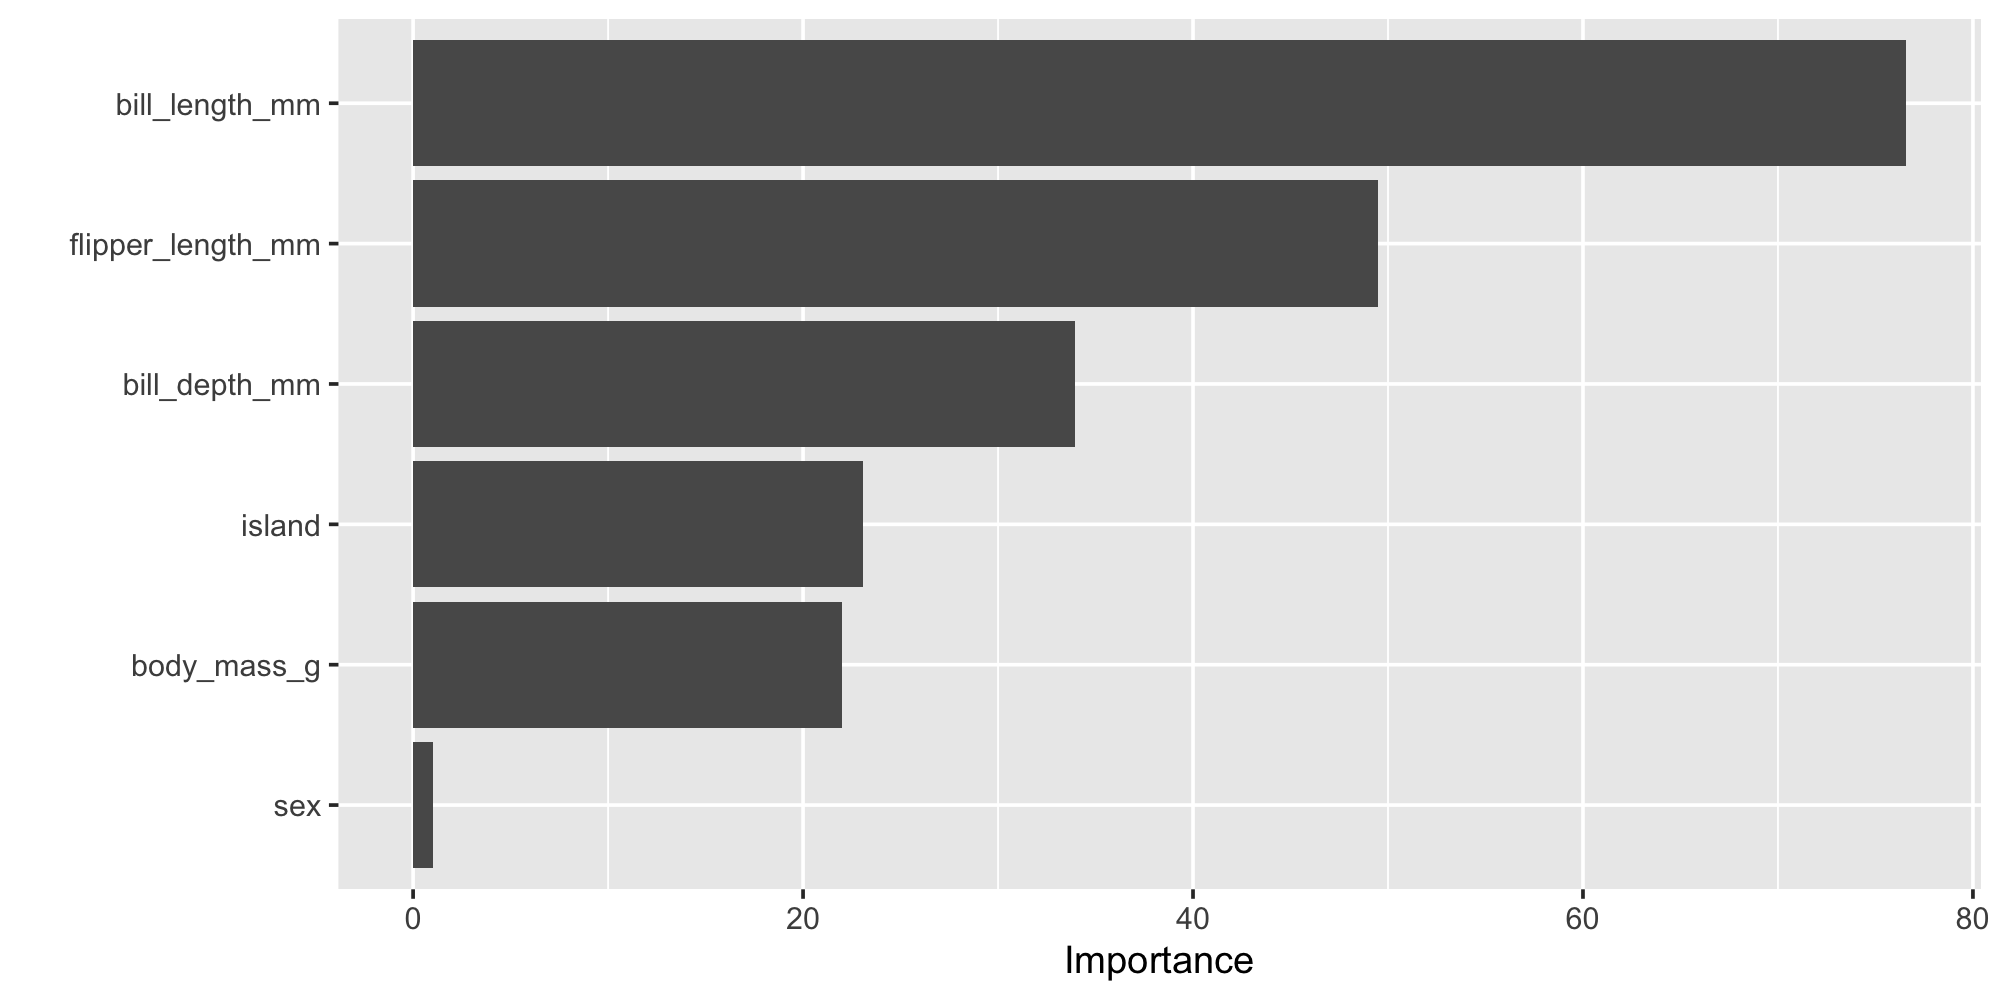

In [21]:
options(repr.plot.height = 4)

mod_fit |> extract_fit_engine() |> vip(num_features = 25)